# WNBA All-Decade Team Award

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

awards_data = pd.read_csv("../../data/initial_data/awards_players.csv")
teams_data = pd.read_csv("../../data/initial_data/teams.csv")
players_teams_clean = pd.read_csv("../awards_data/players_teams_clean.csv")
players_stats = pd.read_csv("../../data/initial_data/players_teams.csv")[['playerID', 'year', 'tmID', 'minutes', 'points', 'rebounds', 
                                                                     'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 
                                                                     'fgMade', 'ftAttempted', 'ftMade']]
players_info = pd.read_csv("../../data/initial_data/players_clean.csv")

## Create All-Decade Team Data

In [55]:
# Join dataset players_teams_clean data with teams_data (team_wins, team_losses, rank, playoff_made)
# Note: players_teams_clean has 'team' column, teams_data has 'tmID' column
alldec_data = players_stats.merge(
    teams_data[['year', 'tmID', 'won', 'lost', 'rank', 'playoff', 'confID']], 
    left_on=['year', 'tmID'], 
    right_on=['year', 'tmID'], 
    how='left'
)

# Rename columns for clarity
alldec_data.rename(columns={
    'won': 'team_wins', 
    'lost': 'team_losses', 
    'rank': 'conference_rank', 
    'playoff': 'playoff_made'
}, inplace=True)

# Drop the duplicate tmID column (we already have 'team')
alldec_data.drop(columns=['tmID'], inplace=True)

# Change Playoff from N / Y to 0 / 1
alldec_data['playoff_made'] = alldec_data['playoff_made'].map({'Y': 1, 'N': 0})
# Change ConfID to numeric  EA / WE to 0 / 1
alldec_data['confID'] = alldec_data['confID'].astype('category').cat.codes

print(f"All-Decade data shape: {alldec_data.shape}")
print(f"\nColumns: {alldec_data.columns.tolist()}")
print(f"\nSample data:")
print(alldec_data.head())

# Save csv (relative path from current location)
alldec_data.to_csv("alldec_data.csv", index=False)
print(f"\n✅ Saved to alldec_data.csv")


All-Decade data shape: (1876, 19)

Columns: ['playerID', 'year', 'minutes', 'points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'team_wins', 'team_losses', 'conference_rank', 'playoff_made', 'confID']

Sample data:
     playerID  year  minutes  points  rebounds  assists  steals  blocks  \
0  abrossv01w     2      846     343       174       53      42       9   
1  abrossv01w     3      805     314       146       60      42      10   
2  abrossv01w     4      792     318       141       82      44      11   
3  abrossv01w     5      462     146        74       45      30       2   
4  abrossv01w     6      777     304       107       60      48       6   

   turnovers  PF  fgAttempted  fgMade  ftAttempted  ftMade  team_wins  \
0         85  70          293     114          132      96         12   
1         92  73          316     119          116      56         10   
2         90  79          285     112        

## Aggregate Player Stats from Previous Years

In [56]:
# Function to aggregate player stats from previous years (up to 10 years back, or available years)
# For award year N, this uses data from years max(1, N-10) to N-1
def create_alldecade_features_for_year(target_year, max_lookback=10):
    """
    Create features for All-Decade Team prediction for target_year.
    Uses player stats from previous years only (NOT including target_year).
    
    Args:
        target_year: The year to predict (award year)
        max_lookback: Maximum years to look back (default 10)
    
    Returns:
        DataFrame with aggregated features for each player
    """
    # Calculate lookback window: start from max(1, target_year - max_lookback) to target_year - 1
    start_year = max(1, target_year - max_lookback)
    end_year = target_year - 1
    
    print(f"\n📊 Creating features for year {target_year}")
    print(f"   Using data from years {start_year} to {end_year} ({end_year - start_year + 1} years)")
    
    # Get players who played in the lookback period
    lookback_data = alldec_data[(alldec_data['year'] >= start_year) & 
                                (alldec_data['year'] <= end_year)].copy()
    
    if lookback_data.empty:
        print(f"   ⚠️ No data available for years {start_year}-{end_year}")
        return pd.DataFrame()
    
    # Calculate EFF (Efficiency rating) for each player-year
    lookback_data['EFF'] = (
        lookback_data['points'] + 
        lookback_data['rebounds'] + 
        lookback_data['assists'] + 
        lookback_data['steals'] + 
        lookback_data['blocks']
    ) - (
        (lookback_data['fgAttempted'] - lookback_data['fgMade']) + 
        (lookback_data['ftAttempted'] - lookback_data['ftMade']) + 
        lookback_data['turnovers']
    )
    
    # Aggregate stats per player across the lookback period
    player_features = lookback_data.groupby('playerID').agg({
        'EFF': 'mean',                      # Average efficiency rating
        'conference_rank': 'mean',          # Average team conference rank
        'team_wins': 'sum',                 # Total team wins accumulated
        'team_losses': 'sum',               # Total team losses accumulated
        'minutes': 'sum',                   # Total minutes played
        'playoff_made': 'sum',              # Total playoff appearances
        'points': 'sum',                    # Total points scored
        'rebounds': 'sum',                  # Total rebounds
        'assists': 'sum',                   # Total assists
        'steals': 'sum',                    # Total steals
        'blocks': 'sum'                     # Total blocks
    }).reset_index()
    
    # Rename columns for clarity
    player_features.columns = [
        'playerID', 'avg_EFF', 'avg_conference_rank', 'total_team_wins', 
        'total_team_losses', 'total_minutes', 'total_playoffs_made',
        'total_points', 'total_rebounds', 'total_assists', 'total_steals', 'total_blocks'
    ]
    
    # Add the target year column
    player_features['award_year'] = target_year
    
    # Calculate games per minute stats (normalized performance)
    player_features['points_per_minute'] = player_features['total_points'] / player_features['total_minutes'].replace(0, 1)
    player_features['rebounds_per_minute'] = player_features['total_rebounds'] / player_features['total_minutes'].replace(0, 1)
    player_features['assists_per_minute'] = player_features['total_assists'] / player_features['total_minutes'].replace(0, 1)
    
    print(f"   ✅ Created features for {len(player_features)} players")
    
    return player_features



## Define Features and Generate Training Data

In [57]:
# Define feature columns for the model
# These features aggregate player performance from PREVIOUS years only
feature_columns = [
    'avg_EFF',                  # Average efficiency rating over previous years
    'avg_conference_rank',      # Average team conference rank
    'total_team_wins',          # Total team wins accumulated
    'total_team_losses',        # Total team losses accumulated
    'total_minutes',            # Total minutes played
    'total_playoffs_made',      # Total playoff appearances
    'total_points',             # Total points scored
    'total_rebounds',           # Total rebounds
    'total_assists',            # Total assists
    'total_steals',             # Total steals
    'total_blocks',             # Total blocks
    'points_per_minute',        # Points per minute (normalized)
    'rebounds_per_minute',      # Rebounds per minute (normalized)
    'assists_per_minute'        # Assists per minute (normalized)
]

print("Features for All-Decade Team prediction:")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i}. {col}")

# Generate features for year 7 (the award year in our dataset)
award_year = 7
os.makedirs("yearly_data", exist_ok=True)

year_7_features = create_alldecade_features_for_year(award_year, max_lookback=10)

# Add target variable (All-Decade Team winners)
all_decade_winners = awards_data[awards_data['award'] == 'WNBA All-Decade Team'][['playerID', 'year']]
all_decade_winners['Target'] = 1

year_7_features = year_7_features.merge(
    all_decade_winners[all_decade_winners['year'] == award_year][['playerID', 'Target']], 
    on='playerID', 
    how='left'
)
year_7_features['Target'] = year_7_features['Target'].fillna(0).astype(int)

print(f"\nDataset Summary:")
print(f"   Total players: {len(year_7_features)}")
print(f"   All-Decade winners: {year_7_features['Target'].sum()}")
print(f"   Non-winners: {(year_7_features['Target'] == 0).sum()}")

# Save to CSV
year_7_features.to_csv(f"yearly_data/alldecade_features_year_{award_year}.csv", index=False)
print(f"\n✅ Saved to yearly_data/alldecade_features_year_{award_year}.csv")


Features for All-Decade Team prediction:
   1. avg_EFF
   2. avg_conference_rank
   3. total_team_wins
   4. total_team_losses
   5. total_minutes
   6. total_playoffs_made
   7. total_points
   8. total_rebounds
   9. total_assists
   10. total_steals
   11. total_blocks
   12. points_per_minute
   13. rebounds_per_minute
   14. assists_per_minute

📊 Creating features for year 7
   Using data from years 1 to 6 (6 years)
   ✅ Created features for 412 players

Dataset Summary:
   Total players: 412
   All-Decade winners: 10
   Non-winners: 402

✅ Saved to yearly_data/alldecade_features_year_7.csv


## Prepare Training Data

In [58]:
# Load the features we just created
data_year_7 = pd.read_csv(f"yearly_data/alldecade_features_year_{award_year}.csv")

# Drop rows with missing values
data_year_7 = data_year_7.dropna(subset=feature_columns)

print(f"📊 Final dataset for training:")
print(f"   Shape: {data_year_7.shape}")
print(f"   Features: {len(feature_columns)}")
print(f"   Samples: {len(data_year_7)}")
print(f"   Winners (Target=1): {data_year_7['Target'].sum()}")
print(f"   Non-winners (Target=0): {(data_year_7['Target'] == 0).sum()}")


📊 Final dataset for training:
   Shape: (412, 17)
   Features: 14
   Samples: 412
   Winners (Target=1): 10
   Non-winners (Target=0): 402


# Section 1: Train/Test Split for Model Evaluation
Train on 70% of year 7 candidates, test on remaining 30%

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Prepare features and target
X = data_year_7[feature_columns]
y = data_year_7['Target']

# Split into train and test (stratified because target is rare)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Store playerIDs for later identification
train_indices = X_train.index
test_indices = X_test.index

print(f"📊 Train/Test Split:")
print(f"   Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"   Training winners: {y_train.sum()}")
print(f"   Testing winners: {y_test.sum()}")


📊 Train/Test Split:
   Training samples: 288 (69.9%)
   Testing samples: 124 (30.1%)
   Training winners: 7
   Testing winners: 3


### Logistic Regression

✅ Logistic Regression Results:
   Train accuracy: 0.986
   Test accuracy: 0.976

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       121
           1       0.50      0.67      0.57         3

    accuracy                           0.98       124
   macro avg       0.75      0.83      0.78       124
weighted avg       0.98      0.98      0.98       124


Top 10 Most Important Features:
            Feature  Coefficient
  points_per_minute     2.326649
       total_points     1.863831
 assists_per_minute     1.497587
            avg_EFF     1.332572
       total_steals    -0.985338
  total_team_losses    -0.540451
avg_conference_rank    -0.442758
rebounds_per_minute    -0.427566
    total_team_wins    -0.247993
total_playoffs_made     0.205214


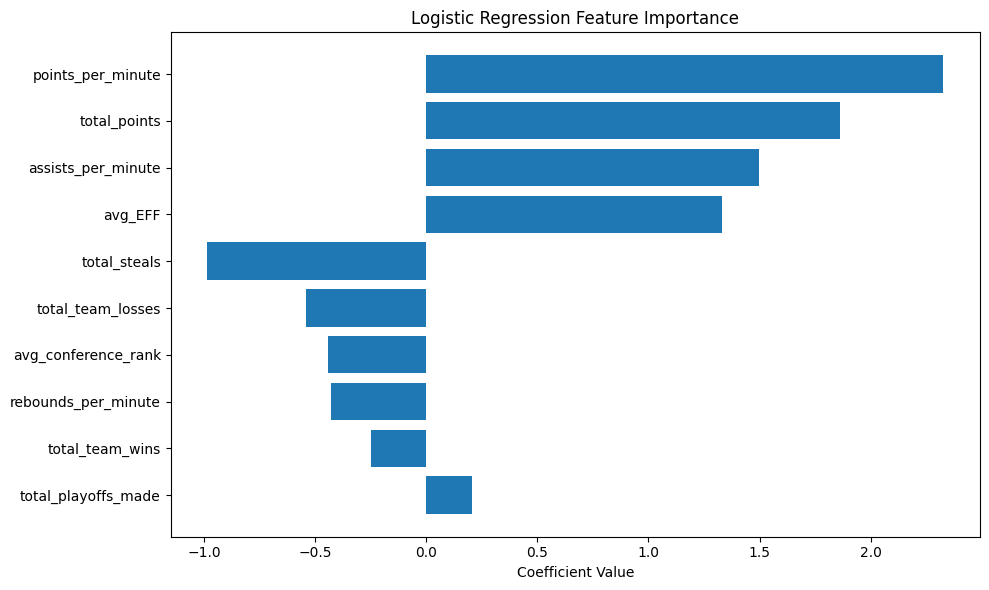

In [60]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with class balancing
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Logistic Regression Results:")
print(f"   Train accuracy: {lr_model.score(X_train_scaled, y_train):.3f}")
print(f"   Test accuracy: {accuracy_score(y_test, y_pred_lr):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_lr))

# Feature Importance
feature_importance_lr = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_lr.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance_lr.head(10)
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### XGBoost

✅ XGBoost Results:
   Train accuracy: 1.000
   Test accuracy: 0.984

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       121
           1       0.67      0.67      0.67         3

    accuracy                           0.98       124
   macro avg       0.83      0.83      0.83       124
weighted avg       0.98      0.98      0.98       124


Top 10 Most Important Features:
            Feature  Importance
            avg_EFF    0.803323
  points_per_minute    0.054834
      total_assists    0.052267
      total_minutes    0.027450
    total_team_wins    0.022371
       total_points    0.012842
 assists_per_minute    0.011145
rebounds_per_minute    0.004576
       total_blocks    0.004358
avg_conference_rank    0.004082
   Train accuracy: 1.000
   Test accuracy: 0.984

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       121


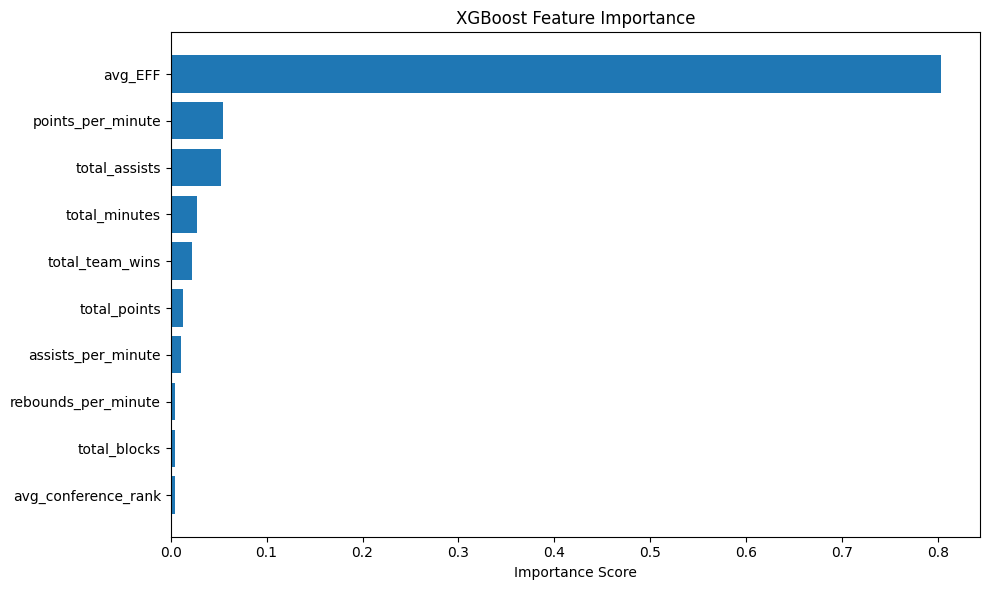

In [61]:
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = len(y_train[y_train == 0]) / max(len(y_train[y_train == 1]), 1)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("✅ XGBoost Results:")
print(f"   Train accuracy: {xgb_model.score(X_train, y_train):.3f}")
print(f"   Test accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_xgb))

# Feature Importance
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_xgb.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features_xgb = feature_importance_xgb.head(10)
plt.barh(top_features_xgb['Feature'], top_features_xgb['Importance'])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Top Predictions (Test Set)

In [62]:
# Create results DataFrame with playerIDs
test_results = data_year_7.loc[test_indices].copy()
test_results['Actual'] = y_test.values
test_results['LR_Prob'] = y_prob_lr
test_results['XGB_Prob'] = y_prob_xgb

print("🏆 Top 15 Predictions by Logistic Regression:")
print(f"{'Rank':<6}{'Player':<15}{'LR Prob':<12}{'XGB Prob':<12}{'Actual'}")
print("-" * 60)
top_lr = test_results.sort_values(by='LR_Prob', ascending=False).head(15)
for idx, (_, row) in enumerate(top_lr.iterrows(), 1):
    actual_marker = "✅ WINNER" if row['Actual'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<15}{row['LR_Prob']:.4f}{'':6}{row['XGB_Prob']:.4f}{'':6}{actual_marker}")

print("\n" + "="*60)
print("\n🏆 Top 15 Predictions by XGBoost:")
print(f"{'Rank':<6}{'Player':<15}{'XGB Prob':<12}{'LR Prob':<12}{'Actual'}")
print("-" * 60)
top_xgb = test_results.sort_values(by='XGB_Prob', ascending=False).head(15)
for idx, (_, row) in enumerate(top_xgb.iterrows(), 1):
    actual_marker = "✅ WINNER" if row['Actual'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<15}{row['XGB_Prob']:.4f}{'':6}{row['LR_Prob']:.4f}{'':6}{actual_marker}")


🏆 Top 15 Predictions by Logistic Regression:
Rank  Player         LR Prob     XGB Prob    Actual
------------------------------------------------------------
1     jacksla01w     0.9939      0.9870      ✅ WINNER
2     holdsch01w     0.9857      0.9954      
3     griffyo01w     0.8078      0.7860      ✅ WINNER
4     cashsw01w      0.7881      0.0071      
5     johnssh01w     0.3784      0.0148      
6     melvich01w     0.1417      0.0126      
7     mcwilta01w     0.1153      0.0111      
8     ferdima01w     0.0919      0.0225      
9     ohldeni01w     0.0829      0.0018      
10    azzije01w      0.0284      0.0172      
11    weckeke01w     0.0170      0.0033      
12    thomala01w     0.0160      0.0020      
13    staleda01w     0.0158      0.0139      ✅ WINNER
14    batkosu01w     0.0142      0.0019      
15    wynneda01w     0.0088      0.0075      


🏆 Top 15 Predictions by XGBoost:
Rank  Player         XGB Prob    LR Prob     Actual
-----------------------------------------

# Section 2: Train Final Model on All Year 7 Data
Use all year 7 data to train production models for future predictions

This section trains final models on ALL year 7 candidates (100% of data) to maximize learning from available examples. These models will be used to predict future All-Decade awards.

In [63]:
print("🎯 Training Final Models on ALL Year 7 Data...")
print(f"   Total samples: {len(data_year_7)}")
print(f"   Winners: {data_year_7['Target'].sum()}")
print(f"   Non-winners: {(data_year_7['Target'] == 0).sum()}")

X_all = data_year_7[feature_columns]
y_all = data_year_7['Target']

# Train final Logistic Regression
scaler_final = StandardScaler()
X_all_scaled = scaler_final.fit_transform(X_all)
lr_model_final = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model_final.fit(X_all_scaled, y_all)

# Train final XGBoost
scale_pos_weight_final = len(y_all[y_all == 0]) / max(len(y_all[y_all == 1]), 1)
xgb_model_final = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_final,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model_final.fit(X_all, y_all)

print("\n✅ Final models trained successfully!")
print("   - Logistic Regression (scaler_final, lr_model_final)")
print("   - XGBoost (xgb_model_final)")
print("\nThese models are ready to predict future All-Decade Teams.")


🎯 Training Final Models on ALL Year 7 Data...
   Total samples: 412
   Winners: 10
   Non-winners: 402

✅ Final models trained successfully!
   - Logistic Regression (scaler_final, lr_model_final)
   - XGBoost (xgb_model_final)

These models are ready to predict future All-Decade Teams.


# Section 3: Predict Future All-Decade Team
Use trained models to predict next All-Decade award (e.g., year 17)

In [64]:
# TEMPLATE: Predict for a future award year
# Example: Predict year 11 All-Decade Team using data from years 1-11

# Set the future award year
future_award_year = 11  # Change this to your target year

print(f"🔮 Predicting All-Decade Team for Year {future_award_year}")
print(f"   Will use player stats from years {max(1, future_award_year-10)} to {future_award_year-1}")
print("\nMake sure alldec_data.csv contains data up to year {0}".format(future_award_year - 1))

# Generate features for the future year
future_features = create_alldecade_features_for_year(future_award_year, max_lookback=10)

if future_features.empty:
    print("\n❌ Cannot generate predictions - insufficient historical data")
else:
    # Prepare features (same columns as training)
    X_future = future_features[feature_columns]
    
    # Make predictions with both models
    X_future_scaled = scaler_final.transform(X_future)
    lr_future_probs = lr_model_final.predict_proba(X_future_scaled)[:, 1]
    xgb_future_probs = xgb_model_final.predict_proba(X_future)[:, 1]
    
    # Create results DataFrame
    future_results = future_features[['playerID']].copy()
    future_results['LR_Prob'] = lr_future_probs
    future_results['XGB_Prob'] = xgb_future_probs
    future_results['Avg_Prob'] = (lr_future_probs + xgb_future_probs) / 2
    
    # Show top candidates
    print(f"\n🏆 Top 15 Candidates for Year {future_award_year} All-Decade Team:")
    print(f"{'Rank':<6}{'Player':<15}{'LR Prob':<12}{'XGB Prob':<12}{'Avg Prob'}")
    print("-" * 65)
    
    top_candidates = future_results.sort_values(by='Avg_Prob', ascending=False).head(15)
    for idx, (_, row) in enumerate(top_candidates.iterrows(), 1):
        print(f"{idx:<6}{row['playerID']:<15}{row['LR_Prob']:.4f}{'':6}{row['XGB_Prob']:.4f}{'':6}{row['Avg_Prob']:.4f}")
    
    # Save predictions
    future_results.to_csv(f"yearly_data/predictions_year_{future_award_year}.csv", index=False)
    print(f"\n✅ Predictions saved to yearly_data/predictions_year_{future_award_year}.csv")


🔮 Predicting All-Decade Team for Year 11
   Will use player stats from years 1 to 10

Make sure alldec_data.csv contains data up to year 10

📊 Creating features for year 11
   Using data from years 1 to 10 (10 years)
   ✅ Created features for 555 players

🏆 Top 15 Candidates for Year 11 All-Decade Team:
Rank  Player         LR Prob     XGB Prob    Avg Prob
-----------------------------------------------------------------
1     catchta01w     0.9999      0.9973      0.9986
2     tauradi01w     1.0000      0.9971      0.9986
3     leslili01w     1.0000      0.9970      0.9985
4     thompti01w     0.9994      0.9967      0.9981
5     jacksla01w     1.0000      0.9937      0.9968
6     pondeca01w     0.9998      0.9883      0.9940
7     smithka01w     0.9999      0.9878      0.9939
8     birdsu01w      1.0000      0.9768      0.9884
9     swoopsh01w     0.9992      0.9719      0.9855
10    holdsch01w     0.9979      0.9702      0.9840
11    beardal01w     0.9929      0.9734      0.9831
12 